# Нейросеть для автодополнения текстов

Проект направлен на обучение нейронной сети для автодополнения текста

Пропишим необходимые импорты и пути.

In [1]:
from collections import Counter
import gc
import ast

import pandas as pd
import numpy as np

import re

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from transformers import AutoTokenizer

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import evaluate

d:\Обучение\Обучение_DL\sprint_2_rnn\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_ROW_DATA = 'data/raw_dataset.txt'
PATH_PROCESSED_DATA = 'data/processed.csv'
PATH_TRAIN_DATA = 'data/train.csv'
PATH_VALID_DATA = 'data/valid.csv'
PATH_TEST_DATA = 'data/test.csv'

PATH_MODEL = 'models/model.pth'

In [3]:
RANDOM_SEED = 123

In [4]:
tqdm.pandas()

## EDA & Preprocessing

### Предобработка и исследование сырого датасета

Прочитаем данные и посмотрим, что они из себя представляют (выведем первые 10 строк)

In [5]:
with open(PATH_ROW_DATA, 'r', encoding='utf-8') as file:
    texts = file.readlines()

In [6]:
texts[:10]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D\n",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!\n",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds\n',
 'my whole body feels itchy and like its on fire \n',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. \n",
 '@Kwesidei not the whole crew \n',
 'Need a hug \n',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?\n",
 "@Tatiana_K nope they didn't have it \n",
 '@twittera que me muera ? \n']

В данных видны следующие проблемы:
1. Некоторые данные начинаютс с указания аккаунта который писал данный твит, а некоторые нет, поэтому эту часть необходимо удалить.
2. Есть ссылки, поэтому их тоже необходимо зачистить.
3. Все твиты из выведенных заканчиваются симоволом переноса строки, это тоже необходимо будет почистить.
4. Есть смайлики. Необходимо посмотреть это только классические смайлики или ещё есть в формате \*смайлик\*.
5. Необходимо всё привести к нижнему регистру.

Напишем функцию, которая решает данные проблемы.

In [7]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'\w*@\w*', ' ', text) # убираем указани аккаунта и почты
    text = re.sub(r'http\S*', ' ', text) # убираем адреса

    text = re.sub(r"[:;=]['\-]?[)d(p]+", ' ', text) # убираем классические смайлики
    text = re.sub(r'\*\w*\*', ' ', text) # убираем смайлики прописанные в формате слов
    # убираем самйлики в формате кодов
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)

    text = re.sub(r'\s+([.,!?;:])', r'\1', text) # убираем висячие знаки припинания
    re.sub(r'([.,!?;:])([^\s])', r'\1 \2', text) # добавляем пробелы после знаков припинания, если их нет

    # заменяем все возможные пробелы, переносы и т.д. на стандартный символ пробела и затем заменяем 2 и более пробелов на 1
    text = re.sub(r'_x000d_\n', ' ', text)
    text = re.sub(r'^\s+|\n', ' ', text)
    text = re.sub(r'  ', ' ', text)
    text = re.sub(r'^ +| +$', '', text) # убираем пробелы в начале и конце строки
    return text

Протестируем на первом примере

In [8]:
clean_text(texts[0])

"- awww, that's a bummer. you shoulda got david carr of third day to do it."

Всё отработало корректно. Почистим все данные и выведем первые 10 примеров.

In [9]:
texts = [clean_text(text) for text in tqdm(texts, desc='Очистка тестка')]

Очистка тестка: 100%|██████████| 1600498/1600498 [00:28<00:00, 55462.52it/s]


In [10]:
texts[:10]

["- awww, that's a bummer. you shoulda got david carr of third day to do it.",
 "is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!",
 'i dived many times for the ball. managed to save 50% the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 "no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.",
 'not the whole crew',
 'need a hug',
 "hey long time no see! yes.. rains a bit,only a bit lol, i'm fine thanks, how's you?",
 "nope they didn't have it",
 'que me muera?']

Посчитаем количество слов в предложениях.

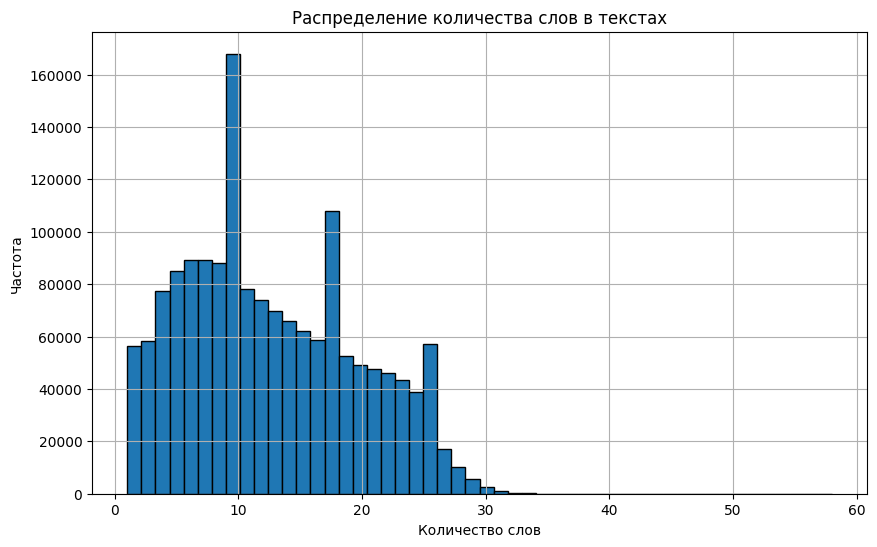

In [11]:
word_counts = [len(text.split(' ')) for text in texts]

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title("Распределение количества слов в текстах")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.grid(True)
plt.show() 

Большинство твитов укладывается в 25 слов, но есть редкие твиты в которых порядка 60 слов. Так же есть много твитов состоящих всего из одного ответа.

Посмотрим на количество предложений в которых количество слов превышает или равно 35.

In [12]:
sum([count >= 35 for count in word_counts])

45

Как видим таких твитов было всего лишь 45, поэтому разумно будет убрать их, что бы не делать слишком большие падинги для всех.

In [13]:
mask = [count < 35 for count in word_counts]
texts = [item for item, mask_value in zip(texts, mask) if mask_value]

Посмотрим насколько часто каждое слово встречается в корпусе.

In [14]:
res = []
[res.extend(text.split(' ')) for text in texts]

count_of_words = Counter(res)

Посмотрим на наиболее частые слова

In [15]:
count_of_words.most_common(10)

[('i', 746460),
 ('to', 559664),
 ('the', 518774),
 ('a', 376417),
 ('my', 312774),
 ('and', 294964),
 ('you', 236360),
 ('is', 230800),
 ('for', 213732),
 ('in', 209798)]

Ожидаемо это местоимения, артикли и предлоги

Теперь на наиболее редкие

In [16]:
count_of_words.most_common()[:-10:-1]

[('#flockofseagullsweregeopoliticallycorrect', 1),
 ('texn3rds', 1),
 ('calcio1', 1),
 ('indesign?:', 1),
 ('typeset', 1),
 ('waster)', 1),
 ('flay...', 1),
 ('(updated:', 1),
 ('$palm', 1)]

Редкими оказались хэштеги, опечатки, в том числе с заменок букв на цифры, просто редкие слова плюс слова со знаками препинания (но в этом виновата наша разбивка).

### Токенизация и создание датасетов

Теперь проведём токенизацию нашего датасета.

In [17]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [18]:
token_texts = [tokenizer(text, truncation=True)['input_ids'] for text in tqdm(texts, desc='Очистка тестка')]

Очистка тестка: 100%|██████████| 1600453/1600453 [02:17<00:00, 11637.34it/s]


Посмотрим на результат

In [19]:
token_texts[0]

[12,
 257,
 2503,
 11,
 326,
 338,
 257,
 275,
 31647,
 13,
 345,
 815,
 64,
 1392,
 21970,
 1097,
 81,
 286,
 2368,
 1110,
 284,
 466,
 340,
 13]

Иеперь нам необходимо сформировать три списка: один данные для обучения, второй - цели обучения, третий - оставшаяся часть текста начиная с цели обучения.

In [20]:
def get_data_and_target(token_texts: list[str]) -> tuple[list[str], list[str]]:
    set_tuple = set()
    data_list = []
    target_list = []
    end_list = []
    for text in tqdm(token_texts, desc='Создание списков для обучения'):
        start_point = int(len(text) / 4 * 3) # По заданию для генерации используем 3/4 текста
        for idx_target in range(max(1, start_point), len(text)):
            # Добавляем только уникальные сочетания data/target чтобы избежать дублей
            item = ' '.join([str(i) for i in text[:idx_target + 1]])
            if (item) not in set_tuple:
                set_tuple.add(item)
                data_list.append(text[:idx_target])
                target_list.append(text[idx_target])
                end_list.append(text[idx_target:])
    return data_list, target_list, end_list

In [21]:
data_list, target_list, end_list = get_data_and_target(token_texts)

Создание списков для обучения: 100%|██████████| 1600453/1600453 [00:32<00:00, 48734.21it/s]


Посмотрим корректно ли всё отработало

In [22]:
data_list[:5]

[[12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368,
  1110],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368,
  1110,
  284],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368,
  1110,
  284,
  466]]

In [23]:
target_list[:5]

[2368, 1110, 284, 466, 340]

In [24]:
end_list[:5]

[[2368, 1110, 284, 466, 340, 13],
 [1110, 284, 466, 340, 13],
 [284, 466, 340, 13],
 [466, 340, 13],
 [340, 13]]

Всё отработало корректно. Теперь создадим датафрейм и сохраним его

In [25]:
df = pd.DataFrame({
    'data': data_list,
    'target': target_list,
    'end_text': end_list
})
df.head()

,data,target,end_text
0,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",2368,"[2368, 1110, 284, 466, 340, 13]"
1,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",1110,"[1110, 284, 466, 340, 13]"
2,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",284,"[284, 466, 340, 13]"
3,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",466,"[466, 340, 13]"
4,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",340,"[340, 13]"


In [26]:
df.shape

(7337114, 3)

Сохраним полученный датафрейм

In [27]:
df.to_csv(PATH_PROCESSED_DATA, index=False)

Разделим датасет на тренировочный, валидационный и тестовый

In [28]:
df_train, df_test= train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_valid, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

Выведем размеры получившихся датасетов

In [29]:
df_train.shape, df_valid.shape, df_test.shape

((5869691, 3), (733711, 3), (733712, 3))

In [30]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Сохраним их.

In [31]:
df_train.to_csv(PATH_TRAIN_DATA, index=False)
df_valid.to_csv(PATH_VALID_DATA, index=False)
df_test.to_csv(PATH_TEST_DATA, index=False)

Удалим ненужные перемнные, чтобы не засорять память.

In [32]:
del texts, token_texts, df
gc.collect()

0

## Modeling

Поскольку в качестве метрики будем использовать rouge, то сразу загрузим ей

In [33]:
rouge = evaluate.load("rouge")

Также проверим доступна ли нам cuda и присвоим соответствующее значение переменной device

In [34]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device='cpu'

print(device)

cuda


### Создание Даталоадеров

Зададим максимальную длину последовательности (как мы знаем она у нас не превышает 35), а также получен токен для паддинга.

In [35]:
MAX_LEN = 35
PAD_TOKEN = tokenizer.pad_token_type_id

Напишем класс датасета

In [36]:
class Custom_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.data = df['data']
        self.target = df['target']
        self.end_text = df['end_text']

    def __len__(self) -> int:
        return len(self.target)
    
    def __getitem__(self, index):
        return {
            'data': torch.tensor(self.data[index], dtype=torch.long),
            'target': torch.tensor(self.target[index], dtype=torch.long),
            'end_text': torch.tensor(self.end_text[index], dtype=torch.long),
        }

Создадим функцию collate_fn для более эффективного создания паддингов

In [37]:
def collate_fn(batch):
    data = [i['data'] for i in batch]
    target = torch.stack([i['target'] for i in batch])
    end_text = [i['end_text'] for i in batch]
    max_len = max([len(i) for i in data])
    max_len = min([MAX_LEN, max_len])

    pad_text = pad_sequence(data, batch_first=True, padding_value=PAD_TOKEN)

    masks = (pad_text != 0).long()

    return {
        'data': pad_text,
        'target': target,
        'end_text': end_text,
        'masks': masks
    }   

Создадим датасеты и даталоадеры и протестируем корректность работы кода.

In [38]:
#######
########
#########
#########3
########3
#########3
#########

In [39]:
train_dataset = Custom_Dataset(df_train)
valid_dataset = Custom_Dataset(df_valid)
test_dataset = Custom_Dataset(df_test)

In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, collate_fn=collate_fn, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)

Создадим отдельный даталоадер для эксперимента с меньшим размером батча

In [41]:
exp_dataloader = DataLoader(train_dataset, batch_size=3, collate_fn=collate_fn, shuffle=False)

In [42]:
for batch in exp_dataloader:
    print('data:\n', batch['data'])
    print('target:\n', batch['target'])
    print('end_text:', batch['end_text'])
    print('masks:', batch['masks'])
    break

data:
 tensor([[20342,   492,   703,   373,   262,  3491, 30784,  3807,   492,  1312,
           691,   760,   530,  1048,   508,  2497,   340,  4145,     0,     0,
             0,     0],
        [ 8807,  1760,   604,  2250,   290,  2319, 23550,   286, 18440,   523,
          1290,  1909,   986,  1521,   423,  1312,  1716,   523, 16931,  3548,
         14643,   783],
        [ 5832,   821,   884,   257,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
target:
 tensor([ 1290,    11, 16443])
end_text: [tensor([ 1290,    11,   523,  1312,   373, 11040]), tensor([ 11, 788, 275,  65,  13]), tensor([16443,  3956])]
masks: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Всё работает корректно, удалим экспериментальный даталоадер

In [43]:
del exp_dataloader
gc.collect()

423

### Создание LSTM модели.

Создадим класс модели.

In [56]:
class LSTMGenerator(nn.Module):
    def __init__(self, tokenizer, embedding_dim=128, hidden_dim=128):
        super().__init__()
        self.tokenizer = tokenizer

        self.embeding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, tokenizer.vocab_size)

    def forward(self, input_ids, attention_mask):
        x = self.embeding(input_ids)
        rnn_out, _ = self.lstm(x)

        rnn_out_normed = self.norm(rnn_out)

        mask = attention_mask.unsqueeze(2).expand_as(rnn_out_normed)
        masked_out = rnn_out_normed * mask
        summed = masked_out.sum(dim=1)
        lengths = attention_mask.sum(dim=1).unsqueeze(1)
        mean_pooled = summed / lengths

        out = self.dropout(mean_pooled)
        logits = self.fc(out)

        return logits
    
    def generate(self, input_ids, attention_mask, max_len=20):
        num_words = 0
        while num_words < max_len:
            logits = self.forward(input_ids, attention_mask)
            token = logits.argmax(dim=1)

            # input_ids = torch.cat((input_ids[0], torch.tensor([token]).to(device))).unsqueeze(dim=0)
            # attention_mask = torch.cat((attention_mask[0], torch.tensor([1]).to(device))).unsqueeze(dim=0)

            input_ids = torch.cat([input_ids, token.unsqueeze(dim=1)], dim=1)
            new_token_mask = (token != tokenizer.eos_token_id).long()
            attention_mask = torch.cat([attention_mask, new_token_mask.unsqueeze(dim=1)], dim=1)
            
            num_words += 1

            # раняя остановка, если все новые токены стали eos
            if new_token_mask.sum() == 0:
                return input_ids.to('cpu')   
                               
        return input_ids.to('cpu')

In [57]:
model = LSTMGenerator(tokenizer).to(device)

Создадим оптимайзер и критерий оцнивания

In [46]:
optimizer = torch.optim.Adam(params=model.parameters(),  lr=5e-3)
criterion = nn.CrossEntropyLoss()

Напишем функцию для тренировки 1 эпохи

In [47]:
def train_epoch(model: LSTMGenerator, loader: DataLoader) -> float:
    train_loss = 0
    model.train()
    for batch in loader:
        data = batch['data'].to(device)
        masks = batch['masks'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        output = model(data, masks)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        train_loss += loss
    
    return train_loss / len(loader)

Напишем функцию для валидации

In [48]:
def eval(model: LSTMGenerator, loader: DataLoader) -> float:
    valid_loss = 0
    preds, trues = [], []
    model.eval()

    for batch in loader:
        data = batch['data'].to(device)
        masks = batch['masks'].to(device)
        target = batch['target'].to(device)

        with torch.no_grad():
            output = model(data, masks)
            loss = criterion(output, target)
            valid_loss += loss

            preds += torch.argmax(output.squeeze(1), dim=1).cpu().tolist()
            trues += target.tolist()

    preds = [tokenizer.decode(pred) for pred in preds]
    trues = [tokenizer.decode(true) for true in trues]

    return valid_loss / len(loader), rouge.compute(predictions = preds, references = trues)['rouge1']

Напишем основной цикл обучения

In [ ]:
PATION = 10
best_val = np.inf
train_losses = []
valid_losses = []
metrics = []

best_epoch = 0
no_improve_epochs = 0

for epoch in range(200):
    train_loss = train_epoch(model, train_dataloader)
    valid_loss, rouge1 = eval(model, valid_dataloader)

    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    metrics.append(rouge1)

    if valid_loss < best_val:
        best_val = valid_loss
        best_epoch = epoch
        no_improve_epochs = 0
        torch.save(model.state_dict(), PATH_MODEL)

    else:
        no_improve_epochs += 1
        if no_improve_epochs > PATION:
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}: Train loss = {train_loss:.4f}")
        print(f"Epoch {epoch+1}: Valid loss = {valid_loss:.4f}, Rouge1 = {rouge1:.4f}") 

print('-' * 20)
print(f'Best epoch: {best_epoch + 1}')
print(f'Best validation loss: {best_val:.4f}')
print(f'Best metric rouge1: {metrics[best_epoch]:.4f}')

Epoch 1: Train loss = 6.1913
Epoch 1: Valid loss = 5.6147, Rouge1 = 0.0878
Epoch 11: Train loss = 5.2861
Epoch 11: Valid loss = 5.2306, Rouge1 = 0.1190


KeyboardInterrupt: 

Построим графики лоссов и метрики

NameError: name 'train_losses' is not defined

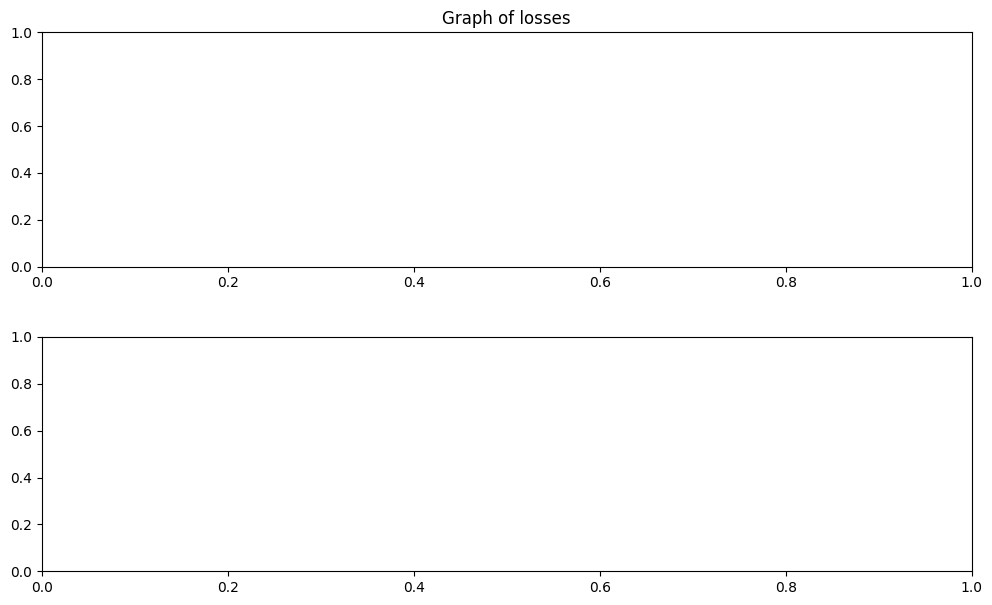

In [49]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.3)

axes[0].set_title(f"Graph of losses")
axes[0].plot(list(range(1, len(train_losses) + 1)), train_losses, label='train')
axes[0].plot(list(range(1, len(valid_losses) + 1)), valid_losses, label='train')
axes[0].axvline(best_epoch + 1, linestyle='--', color='r')
axes[0].legend()
axes[0].grid()
axes[0].text(best_epoch + 1,
            max([min(train_losses), min(valid_losses)]) + 0.3 * (max(train_losses) - min(train_losses)),
            f'best epoch = {best_epoch + 1}',
            size=10,
            alpha=0.8,
            rotation='vertical',
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
            )


axes[1].set_title(f"Graph of metric rouge1")
axes[1].plot(list(range(1, len(metrics) + 1)), metrics)
axes[1].axvline(best_epoch + 1, linestyle='--', color='r')
axes[1].grid()
axes[1].text(best_epoch + 1,
            min(metrics) + 0.1 * (max(metrics) - min(metrics)),
            f'best epoch = {best_epoch + 1}',
            size=10,
            alpha=0.8,
            rotation='vertical',
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
            )

Загрузим лучшую обученную модель

In [58]:
model.load_state_dict(torch.load(PATH_MODEL, weights_only=True))

<All keys matched successfully>

Напишем функцию для генерации текста, которая будет сразу проводить ткоенезацию в прямом и обратном направлении.

In [59]:
def generate(model: LSTMGenerator, text: str, max_token:int = 20) -> str:
    token = tokenizer(text.lower())
    text = token['input_ids']
    masks = token['attention_mask']
    answ = model.generate(torch.tensor(text, dtype=torch.long).unsqueeze(dim=1).to(device), torch.tensor(masks, dtype=torch.long).unsqueeze(dim=1).to(device), max_token)
    answ = tokenizer.decode(answ[0][len(text):])
    return answ

In [60]:
generate(model, 'I want to')


". i'm so sad. i miss my mom. i'm so sad. i'm"

In [62]:
generate(model, 'Here are you, I find')

' coffee!!atmeal!atmeal~atmeal milk coffee* coffee coffee coffee!'

Моделька иногда галюцианирует и зацикливается, но местами смысл и правильный порядок слов наблюдается.

Пройдёмся по тестовому датасету и посмотрим на качество модели.

In [63]:
model.eval()
preds, trues = [], []

for batch in test_dataloader:
    data = batch['data'].to(device)
    masks = batch['masks'].to(device)
    end_text = batch['end_text']

    with torch.no_grad():
        output = model.generate(data, masks)
        preds += output
        trues += end_text

preds = [tokenizer.decode(pred) for pred in preds]
trues = [tokenizer.decode(true) for true in trues]

results = rouge.compute(predictions = preds, references = trues)

for key, value in results.items():
    print(f"{key}: {value:.4f}") 

rouge1: 0.0295
rouge2: 0.0019
rougeL: 0.0278
rougeLsum: 0.0278
